In [7]:
# This block aims to import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import os


!pip install openpyxl


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
#Bloque de configuración de rutas

# Tipo de cambio
file_path_tdc =r'C:\Users\juanm\OneDrive\Documents\CODER DATA ANALYTICS\GitHub\Prueba_Nacho\files\TDC_vend_BNA_xlsx.xlsx'

# Folder path containing all your files
folder_path = r'C:\Users\juanm\OneDrive\Documents\CODER DATA ANALYTICS\GitHub\Prueba_Nacho\files\proovs_xlsx'
# List all files in the directory
files = ['112garri.xlsx','048korzi.xlsx','500domin.xlsx','1382remo.xlsx','1569brag.xlsx','235erriq.xlsx','627spi.xlsx','025nunci.xlsx','130moscu.xlsx', '132saume.xlsx', '329zonac.xlsx', '332elfar.xlsx']  # List of files to process

In [13]:
# Define functions

def import_excel_file_as_pd_df(file_path_to_import: str) -> pd.DataFrame:
    """This is a simple function to import Excel files into a pandas DataFrame."""
    df = pd.read_excel(file_path_to_import, engine='openpyxl', skiprows=[1, 2],header=0)
    return df

def get_file_name(file_path: str) -> str:
    return os.path.splitext(os.path.basename(file_path))[0]

def process_exchange_rate(data_tdc: pd.DataFrame) -> pd.DataFrame:
    """
    Process 'tipo_cambio_bna_vendedor' column in the given DataFrame.

    Parameters:
    - data_tdc (pd.DataFrame): Input DataFrame with 'indice_tiempo' and 'tipo_cambio_bna_vendedor' columns.

    Returns:
    - pd.DataFrame: Modified DataFrame with filtered and divided values.
    """
    # Create a copy of 'data_tdc' to store the original values
    data_tdc_copy = data_tdc[['indice_tiempo', 'tipo_cambio_bna_vendedor']].copy()

    # Filter values greater than 1000 in 'tipo_cambio_bna_vendedor'
    filtered_values = data_tdc[data_tdc['tipo_cambio_bna_vendedor'] > 1000]

    # Display filtered values and shape
    print(filtered_values.head())
    print(filtered_values.shape)

    # Divide 'tipo_cambio_bna_vendedor' by 1000
    filtered_values['tipo_cambio_bna_vendedor'] = filtered_values['tipo_cambio_bna_vendedor'] / 1000

    # Replace values in 'data_tdc'
    data_tdc.loc[filtered_values.index, 'tipo_cambio_bna_vendedor'] = filtered_values['tipo_cambio_bna_vendedor']

    return data_tdc

def merge_tdc_proov(df: pd.DataFrame, data_tdc: pd.DataFrame) -> pd.DataFrame:
    """
    Process df and data_tdc to join both tables on the date and its correspondent exchange rate.

    Parameters:
    - df (pd.DataFrame) : Values of the supplier's current account
    - data_tdc (pd.DataFrame): Input DataFrame with 'indice_tiempo' and 'tipo_cambio_bna_vendedor' columns.

    Returns:
    - merged (pd.DataFrame): df with addition of the column tipo_de_cambio_vendedor_bna from data_tdc
    """
    # Hago un merge de Tablas para suplir la Query de SQL
    # Assuming 'FECHA' is the column with dates in your DataFrame 'data', convert to date type.
    df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d-%b-%y')
    # Elimino las filas donde HABER es 0. Las filas donde HABER=0 corresponden a Recibos o Notas de Crédito.
    df_clean = df[df['HABER'] != 0]

    # Hago el Merge: Perform a left merge similar to SQL's LEFT JOIN
    merged = df_clean.merge(data_tdc[['indice_tiempo', 'tipo_cambio_bna_vendedor']],
                            how='left',
                            left_on='FECHA',
                            right_on='indice_tiempo')

    pd_to_return = merged.drop('indice_tiempo', axis=1)
    return pd_to_return  # Return the merged DataFrame


def calculate_haber_usd(merged: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate 'HABER_USD' column using safe division in the given DataFrame.

    Parameters:
    - merged (pd.DataFrame): Input DataFrame with 'HABER' and 'tipo_cambio_bna_vendedor' columns.

    Returns:
    - pd.DataFrame: Modified DataFrame with the new 'HABER_USD' column.
    """
    # Create a new column 'HABER_USD' using safe division
    merged['HABER_USD'] = merged['HABER'] / merged['tipo_cambio_bna_vendedor'].replace({0: pd.NaT})

    return merged

def calculate_monthly_sum_two_steps(df: pd.DataFrame, column_name: str, frequency: str) -> pd.Series:
    """
    Convert date to period and then group by the specified frequency to calculate the sum of the given column.

    Parameters:
    - merged (pd.DataFrame): Input DataFrame.
    - column_name (str): Name of the column to calculate the sum.
    - frequency (str): Frequency string, e.g., 'M' for month.

    Returns:
    - pd.Series: Series with the monthly sums.
    """
    # Convert date to period
    df['period'] = df['FECHA'].dt.to_period(frequency)

    # Group by the specified frequency and calculate the sum
    monthly_sum = df.groupby('period')[column_name].sum()

    return monthly_sum



def plot_monthly_sum(monthly_sum: pd.Series, column_name: str, plot_type: str = 'bar'):
    """
    Plot a chart for the monthly sum of a specified column.

    Parameters:
    - monthly_sum (pd.Series): Series with the monthly sums.
    - column_name (str): Name of the column to plot.
    - plot_type (str): Type of plot, 'bar' or 'line'. Default is 'bar'.
    """
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    if plot_type == 'bar':
        monthly_sum.plot(kind='bar', color='skyblue')
        plt.ylabel(f'Total {column_name}')
        plt.title(f'Total {column_name} per Month')
    elif plot_type == 'line':
        monthly_sum.plot(marker='o')
        plt.ylabel(f'Total Amount')
        plt.title(f'Total {column_name}')
        plt.legend([column_name])

    plt.xlabel('Month')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

def plot_monthly_sum_with_filename(monthly_sum: pd.Series, column_name: str, file_path: str, plot_type: str = 'bar'):
    """
    Plot a chart for the monthly sum of a specified column with the file name in the title.

    Parameters:
    - monthly_sum (pd.Series): Series with the monthly sums.
    - column_name (str): Name of the column to plot.
    - file_path (str): Path of the file for extracting the name.
    - plot_type (str): Type of plot, 'bar' or 'line'. Default is 'bar'.
    """
    file_name = get_file_name(file_path)
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    if plot_type == 'bar':
        monthly_sum.plot(kind='bar', color='skyblue')
        plt.ylabel(f'Total {column_name}')
        plt.title(f'Total {column_name} for {file_name}')
    elif plot_type == 'line':
        monthly_sum.plot(marker='o')
        plt.ylabel(f'Total Amount')
        plt.title(f'Total {column_name} for {file_name}')
        plt.legend([column_name])

    plt.xlabel('Month')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()



def report_metrics(merged:pd.DataFrame):
    """
    Report the central measures for each year

    Parameters:
    merged (pd.DataFrame): df with addition of the column tipo_de_cambio_vendedor_bna from data_tdc
    returns String with metric info
    """
    # Calculate mean and median of HABER_USD by year
    merged['Year'] = merged['FECHA'].dt.year  # Extract year from the 'FECHA' column

    # Group by year and calculate mean and median
    yearly_stats = merged.groupby('Year')['HABER_USD'].agg(['mean', 'median','sum', 'count'])

    # Extract file name from file path
    file_name = get_file_name(file_path)

    # Iterate through each year and print the summary text
    for year, data in yearly_stats.iterrows():
        mean_value = data['mean']
        median_value = data['median']
        total_sum = data['sum']
        count_rows = data['count']
        print(f"La compra media en el proveedor {file_name} en {year} fue de {mean_value:.2f} USD, y la mediana fue de {median_value:.2f} USD.El total de compras fue de {total_sum:.2f} USD "
              f"y la cantidad de operaciones fue de {count_rows}.")


In [16]:
# Lets import static file for exchange rate
usd_to_ars_df = import_excel_file_as_pd_df(file_path_tdc)
clean_exc_rate = process_exchange_rate(usd_to_ars_df)

    indice_tiempo  tipo_cambio_bna_vendedor
216    2015-08-07                    9215.0
217    2015-08-08                    9215.0
218    2015-08-09                    9215.0
220    2015-08-11                    9225.0
222    2015-08-13                    9235.0
(68, 2)


C:\Users\juanm\AppData\Local\Temp\ipykernel_7144\3117198387.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values['tipo_cambio_bna_vendedor'] = filtered_values['tipo_cambio_bna_vendedor'] / 1000


In [17]:
# In this Block I generate the empty result_df for latter analysis
# Create a DataFrame to store the results
result_df = pd.DataFrame(columns=['Year'])

# Generate the Month&Year column in the result DataFrame
start_date = pd.to_datetime('2016')  # Start date for the period
end_date = pd.to_datetime('2023')  # End date for the period

# Generate the Month&Year values for the first column
result_df['Year'] = pd.date_range(start=start_date, end=end_date, freq='Y').year

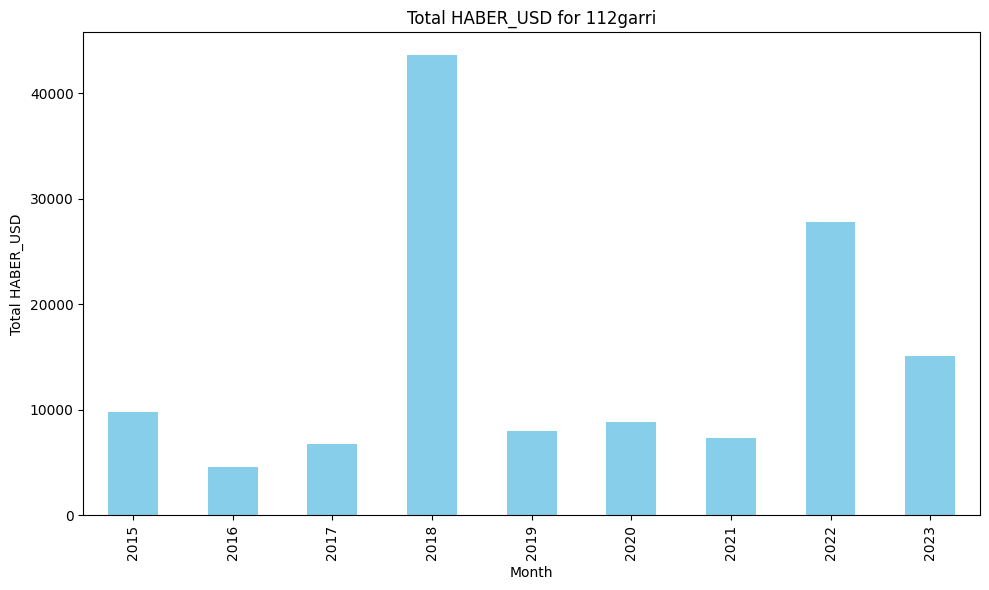

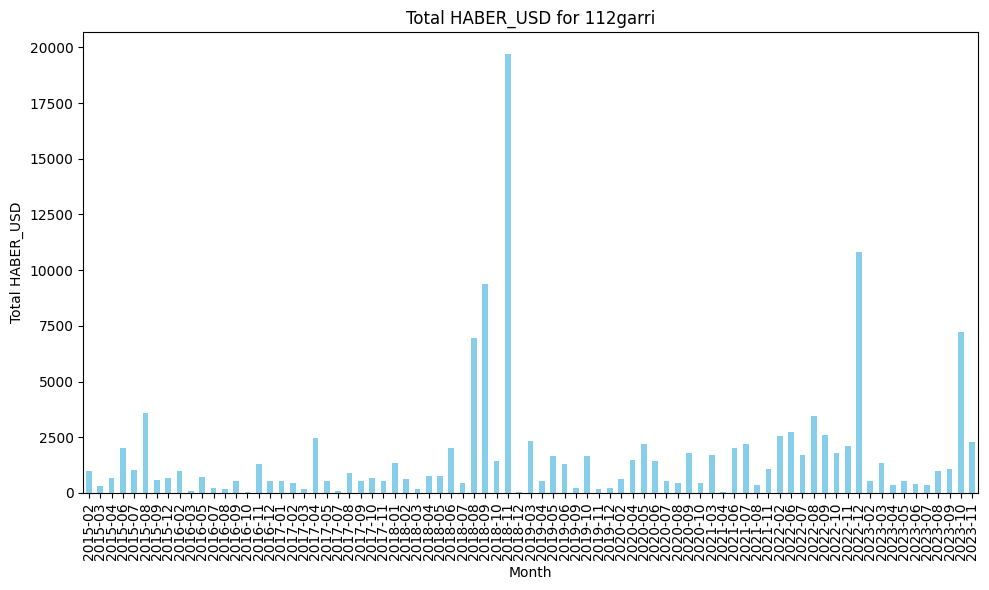

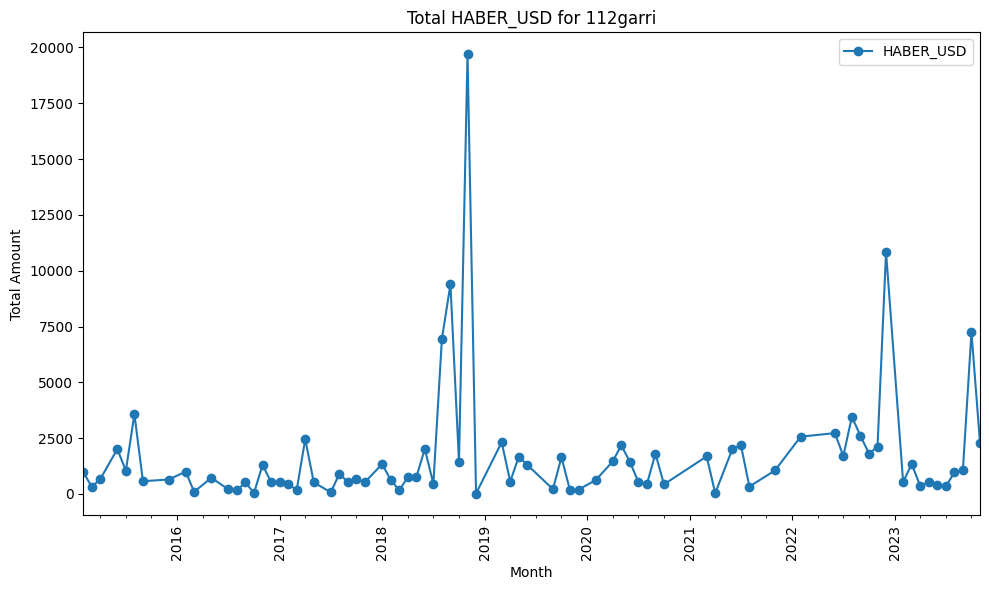

La compra media en el proveedor 112garri en 2015 fue de 576.71 USD, y la mediana fue de 404.05 USD.El total de compras fue de 9804.10 USD y la cantidad de operaciones fue de 17.0.
La compra media en el proveedor 112garri en 2016 fue de 207.14 USD, y la mediana fue de 166.27 USD.El total de compras fue de 4557.05 USD y la cantidad de operaciones fue de 22.0.
La compra media en el proveedor 112garri en 2017 fue de 242.95 USD, y la mediana fue de 151.11 USD.El total de compras fue de 6802.65 USD y la cantidad de operaciones fue de 28.0.
La compra media en el proveedor 112garri en 2018 fue de 807.21 USD, y la mediana fue de 155.77 USD.El total de compras fue de 43589.54 USD y la cantidad de operaciones fue de 54.0.
La compra media en el proveedor 112garri en 2019 fue de 217.47 USD, y la mediana fue de 127.08 USD.El total de compras fue de 8046.29 USD y la cantidad de operaciones fue de 37.0.
La compra media en el proveedor 112garri en 2020 fue de 423.49 USD, y la mediana fue de 171.01 USD.

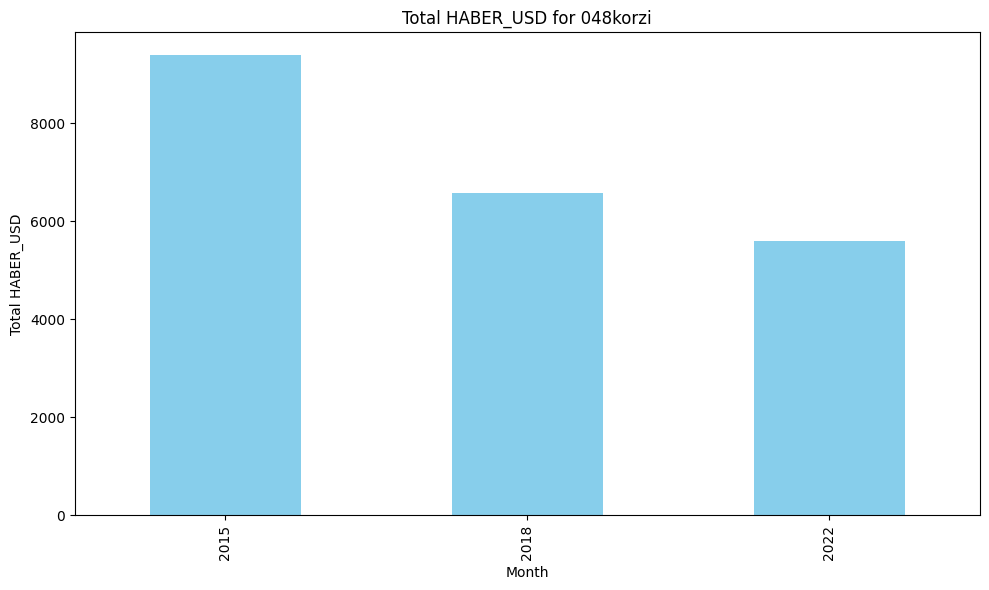

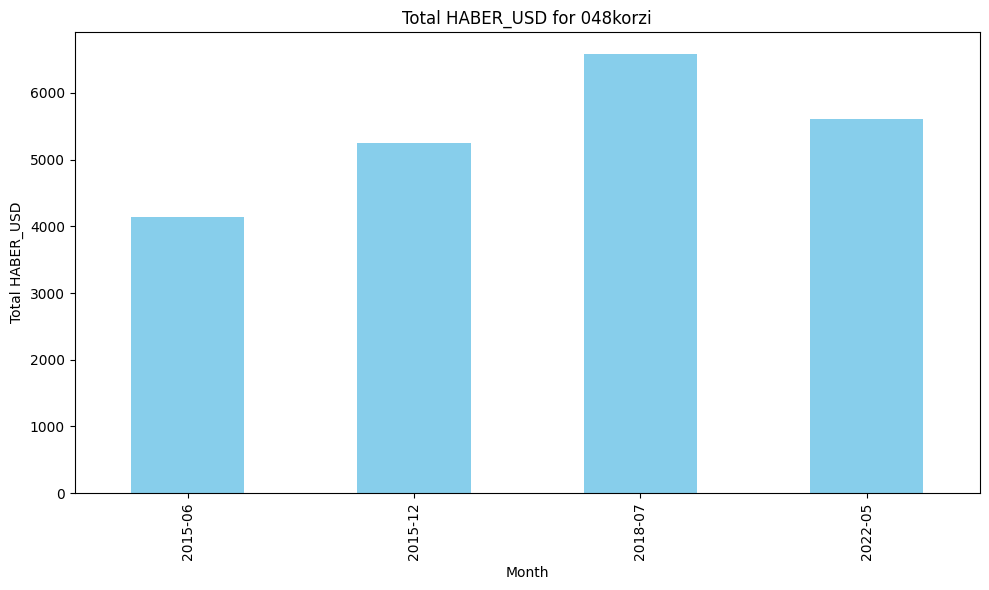

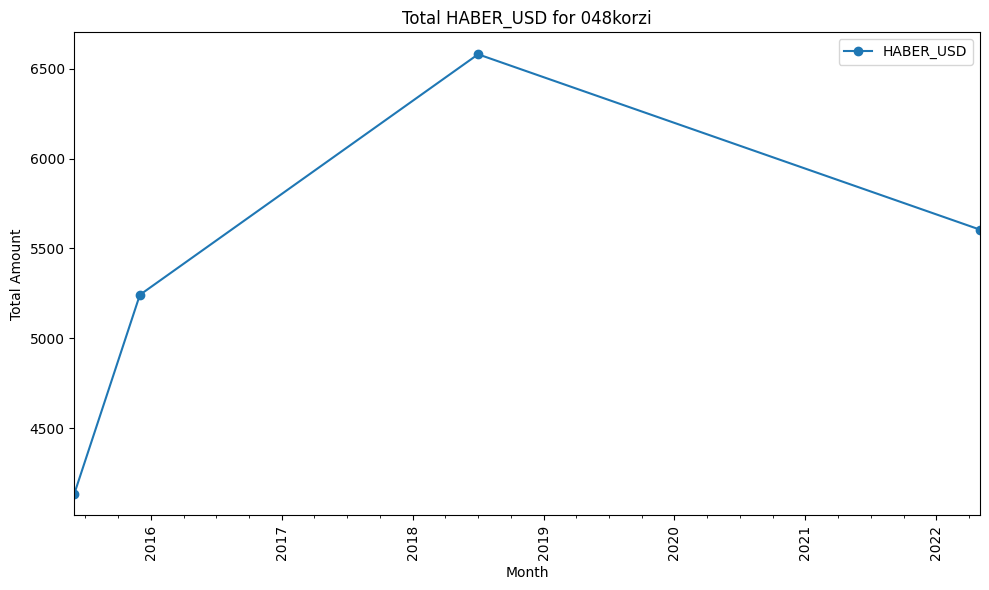

La compra media en el proveedor 048korzi en 2015 fue de 4690.24 USD, y la mediana fue de 4690.24 USD.El total de compras fue de 9380.49 USD y la cantidad de operaciones fue de 2.0.
La compra media en el proveedor 048korzi en 2018 fue de 6579.24 USD, y la mediana fue de 6579.24 USD.El total de compras fue de 6579.24 USD y la cantidad de operaciones fue de 1.0.
La compra media en el proveedor 048korzi en 2022 fue de 5604.72 USD, y la mediana fue de 5604.72 USD.El total de compras fue de 5604.72 USD y la cantidad de operaciones fue de 1.0.


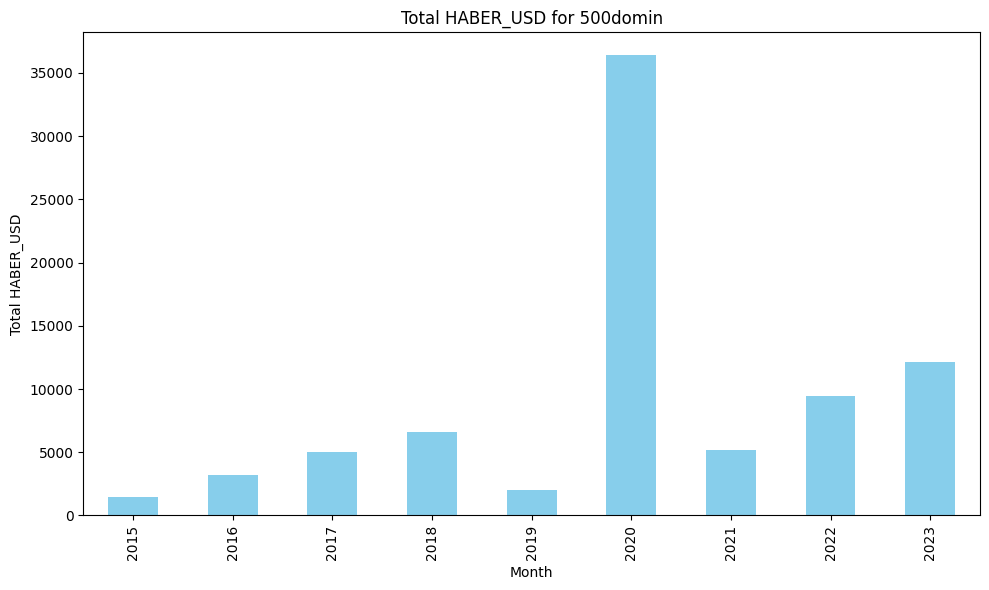

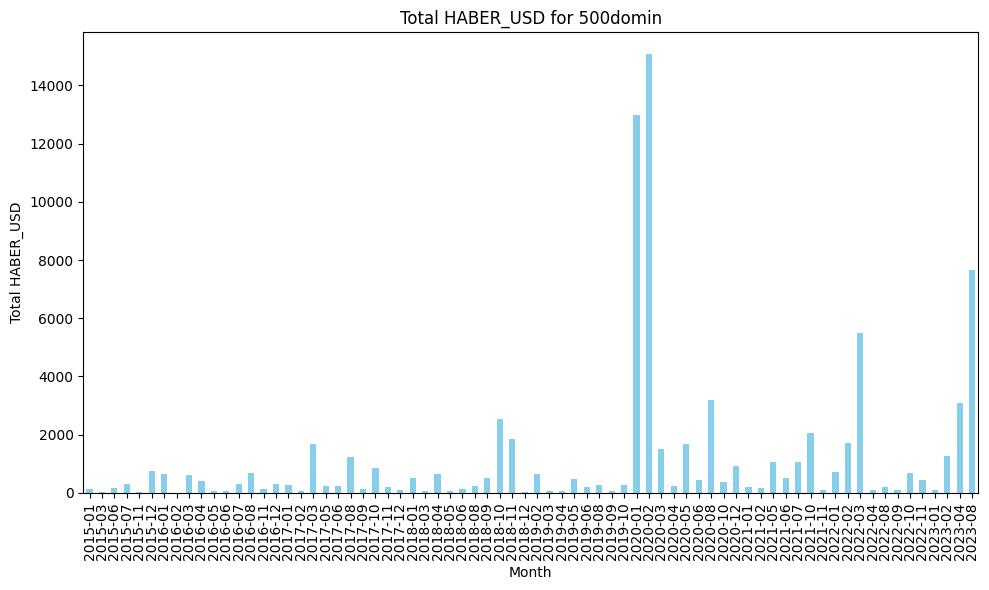

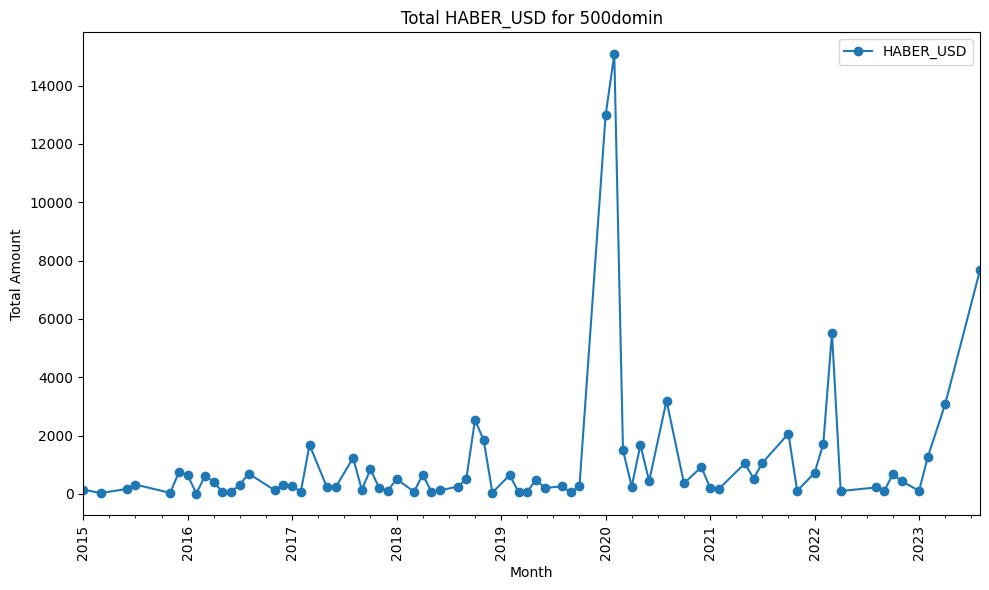

La compra media en el proveedor 500domin en 2015 fue de 159.87 USD, y la mediana fue de 147.56 USD.El total de compras fue de 1438.83 USD y la cantidad de operaciones fue de 9.0.
La compra media en el proveedor 500domin en 2016 fue de 140.65 USD, y la mediana fue de 107.29 USD.El total de compras fue de 3234.89 USD y la cantidad de operaciones fue de 23.0.
La compra media en el proveedor 500domin en 2017 fue de 216.52 USD, y la mediana fue de 161.58 USD.El total de compras fue de 4979.94 USD y la cantidad de operaciones fue de 23.0.
La compra media en el proveedor 500domin en 2018 fue de 226.95 USD, y la mediana fue de 102.49 USD.El total de compras fue de 6581.58 USD y la cantidad de operaciones fue de 29.0.
La compra media en el proveedor 500domin en 2019 fue de 118.86 USD, y la mediana fue de 76.45 USD.El total de compras fue de 2020.57 USD y la cantidad de operaciones fue de 17.0.
La compra media en el proveedor 500domin en 2020 fue de 1399.34 USD, y la mediana fue de 400.88 USD.El

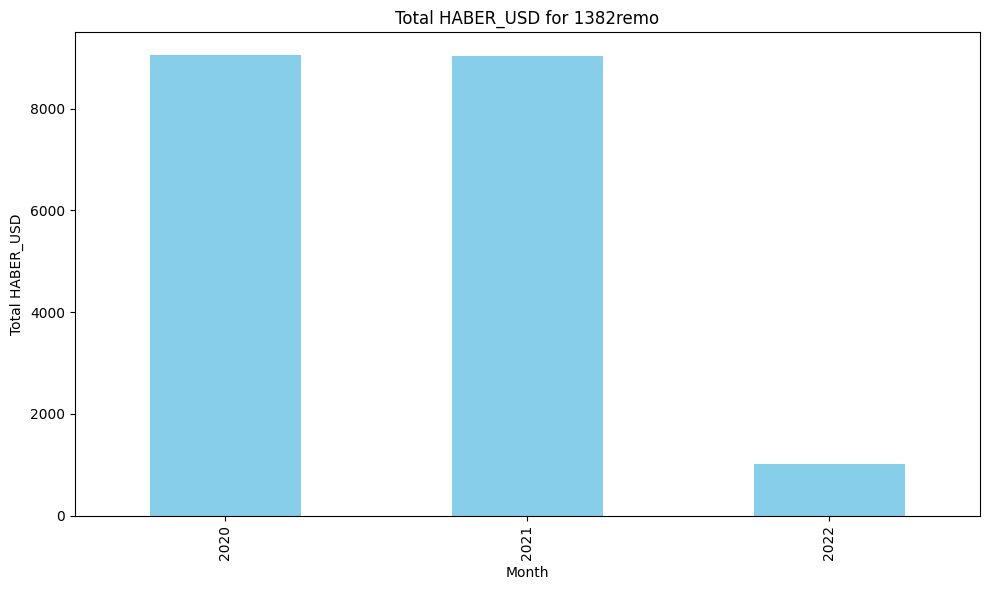

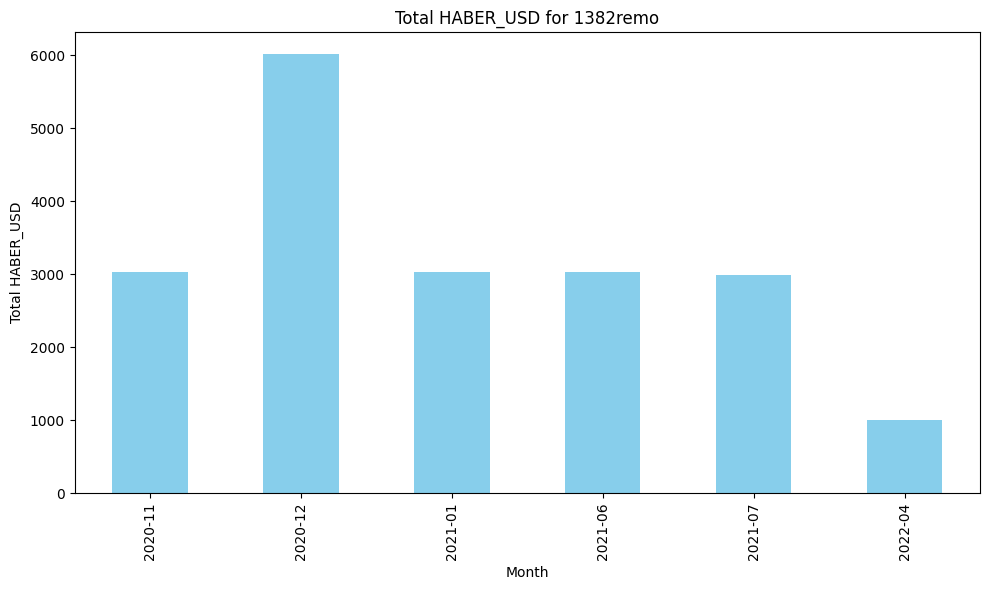

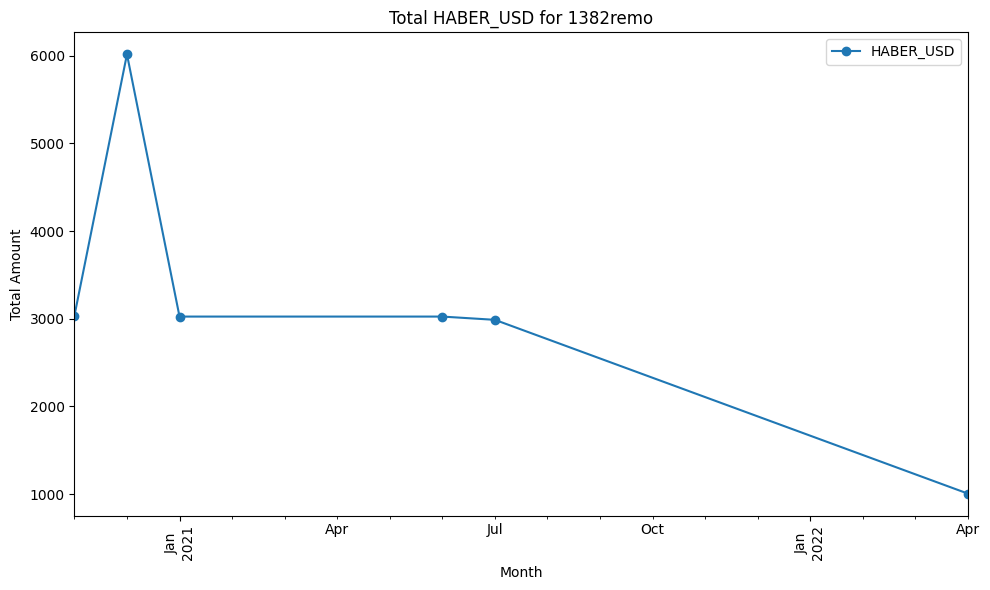

La compra media en el proveedor 1382remo en 2020 fue de 3016.41 USD, y la mediana fue de 3025.00 USD.El total de compras fue de 9049.22 USD y la cantidad de operaciones fue de 3.0.
La compra media en el proveedor 1382remo en 2021 fue de 3012.61 USD, y la mediana fue de 3025.00 USD.El total de compras fue de 9037.84 USD y la cantidad de operaciones fue de 3.0.
La compra media en el proveedor 1382remo en 2022 fue de 1006.23 USD, y la mediana fue de 1006.23 USD.El total de compras fue de 1006.23 USD y la cantidad de operaciones fue de 1.0.


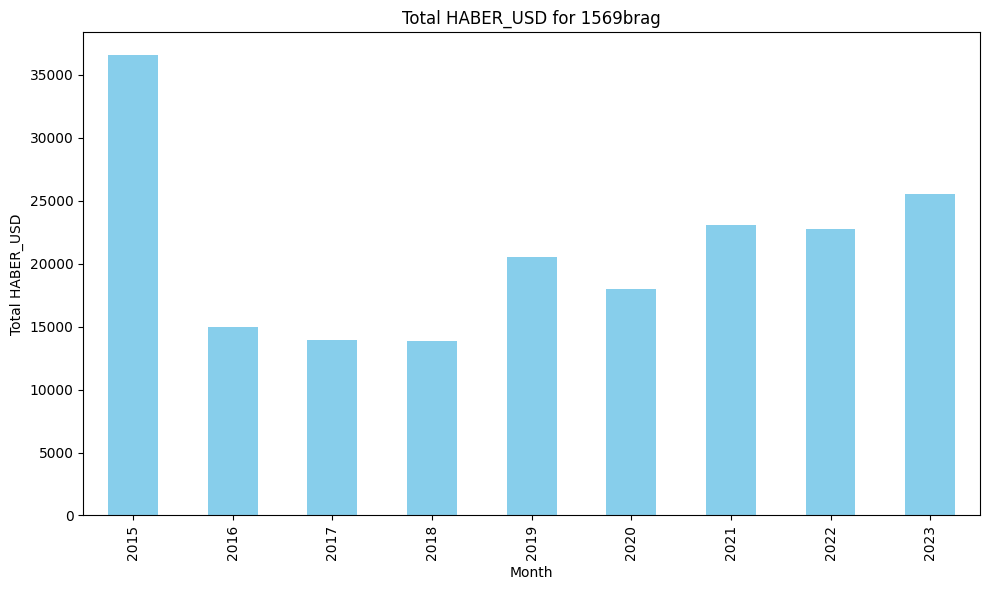

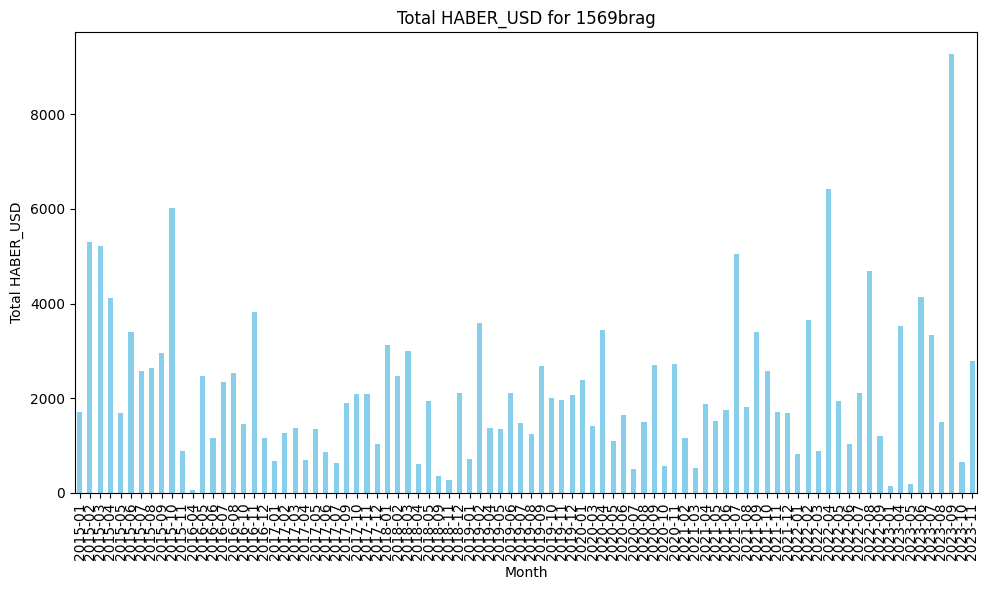

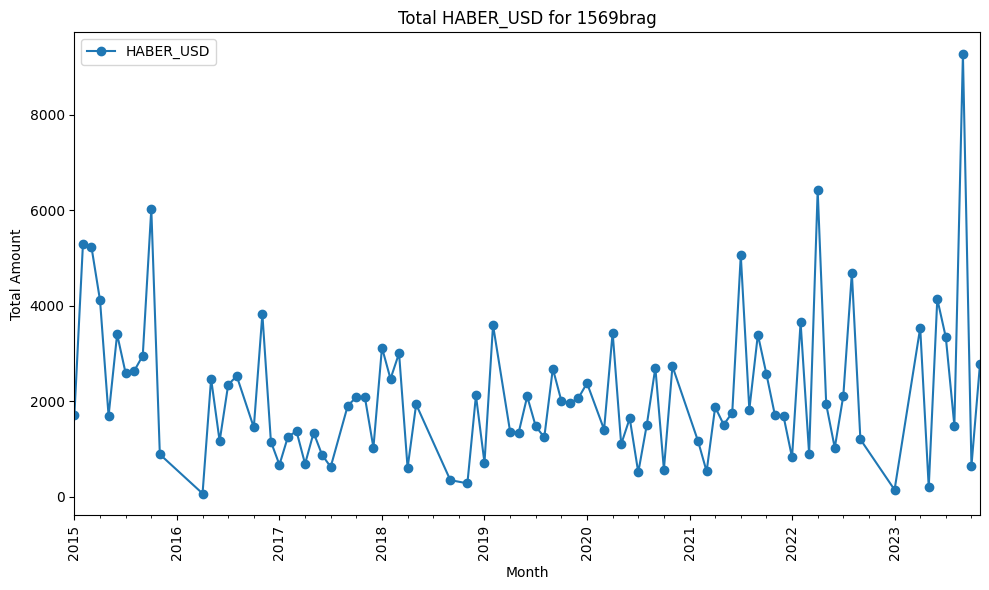

La compra media en el proveedor 1569brag en 2015 fue de 1260.02 USD, y la mediana fue de 1029.71 USD.El total de compras fue de 36540.64 USD y la cantidad de operaciones fue de 29.0.
La compra media en el proveedor 1569brag en 2016 fue de 1000.09 USD, y la mediana fue de 1153.62 USD.El total de compras fue de 15001.34 USD y la cantidad de operaciones fue de 15.0.
La compra media en el proveedor 1569brag en 2017 fue de 662.59 USD, y la mediana fue de 683.28 USD.El total de compras fue de 13914.31 USD y la cantidad de operaciones fue de 21.0.
La compra media en el proveedor 1569brag en 2018 fue de 1067.50 USD, y la mediana fue de 651.11 USD.El total de compras fue de 13877.46 USD y la cantidad de operaciones fue de 13.0.
La compra media en el proveedor 1569brag en 2019 fue de 978.05 USD, y la mediana fue de 699.35 USD.El total de compras fue de 20539.03 USD y la cantidad de operaciones fue de 21.0.
La compra media en el proveedor 1569brag en 2020 fue de 998.92 USD, y la mediana fue de 66

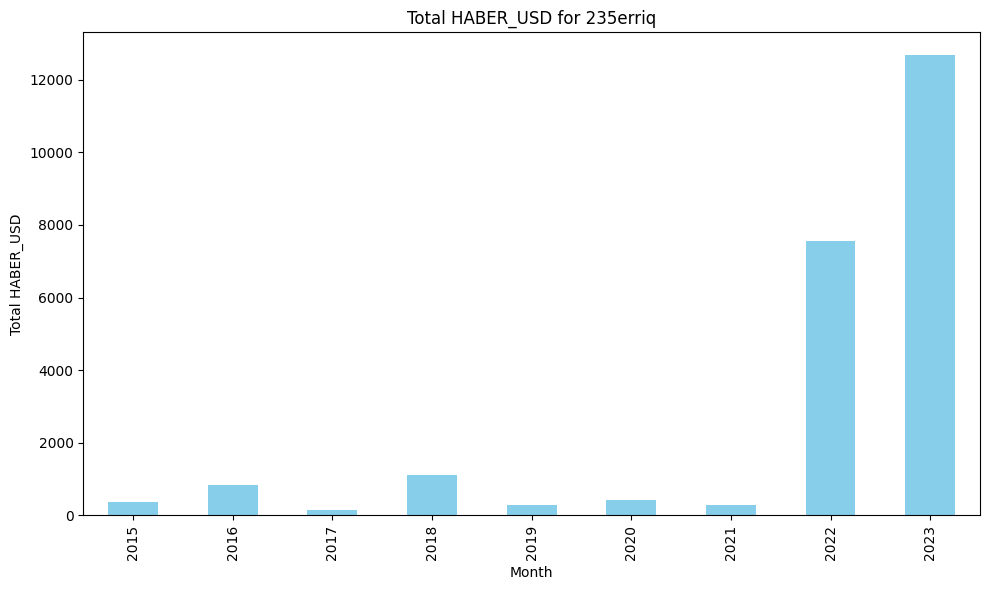

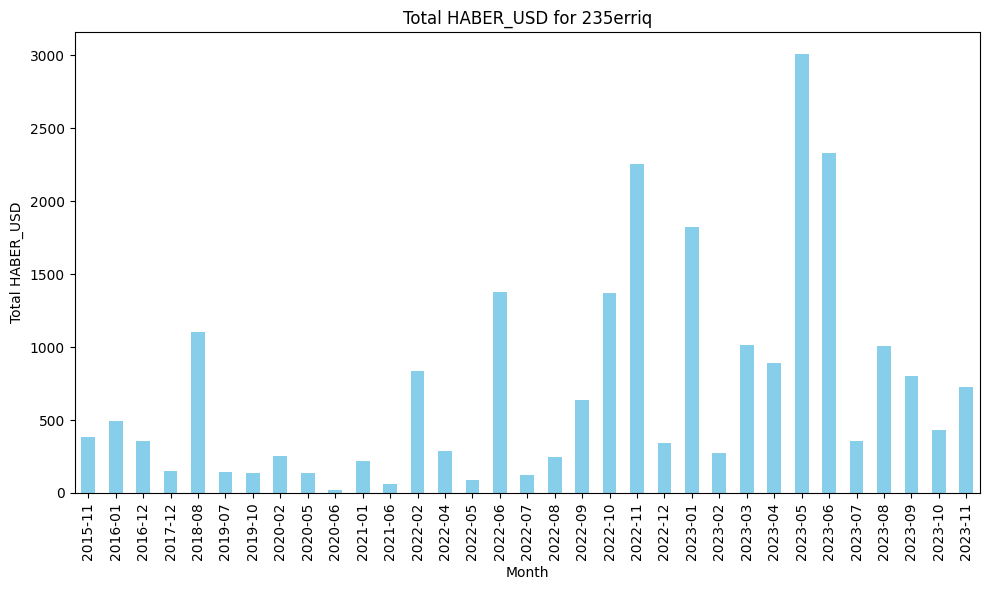

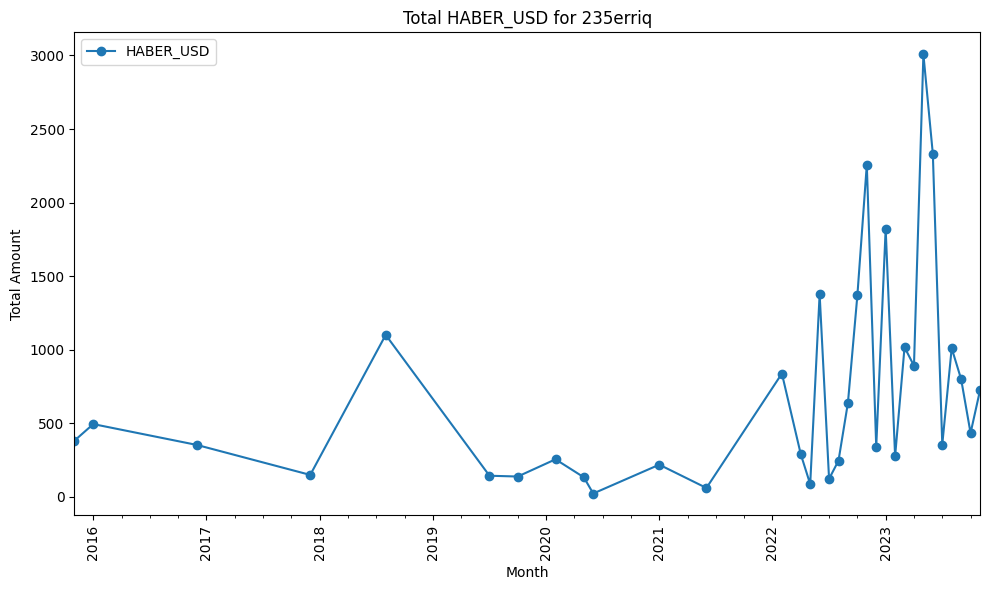

La compra media en el proveedor 235erriq en 2015 fue de 382.27 USD, y la mediana fue de 382.27 USD.El total de compras fue de 382.27 USD y la cantidad de operaciones fue de 1.0.
La compra media en el proveedor 235erriq en 2016 fue de 282.75 USD, y la mediana fue de 250.65 USD.El total de compras fue de 848.24 USD y la cantidad de operaciones fue de 3.0.
La compra media en el proveedor 235erriq en 2017 fue de 149.74 USD, y la mediana fue de 149.74 USD.El total de compras fue de 149.74 USD y la cantidad de operaciones fue de 1.0.
La compra media en el proveedor 235erriq en 2018 fue de 550.55 USD, y la mediana fue de 550.55 USD.El total de compras fue de 1101.09 USD y la cantidad de operaciones fue de 2.0.
La compra media en el proveedor 235erriq en 2019 fue de 141.50 USD, y la mediana fue de 141.50 USD.El total de compras fue de 282.99 USD y la cantidad de operaciones fue de 2.0.
La compra media en el proveedor 235erriq en 2020 fue de 103.24 USD, y la mediana fue de 91.48 USD.El total de

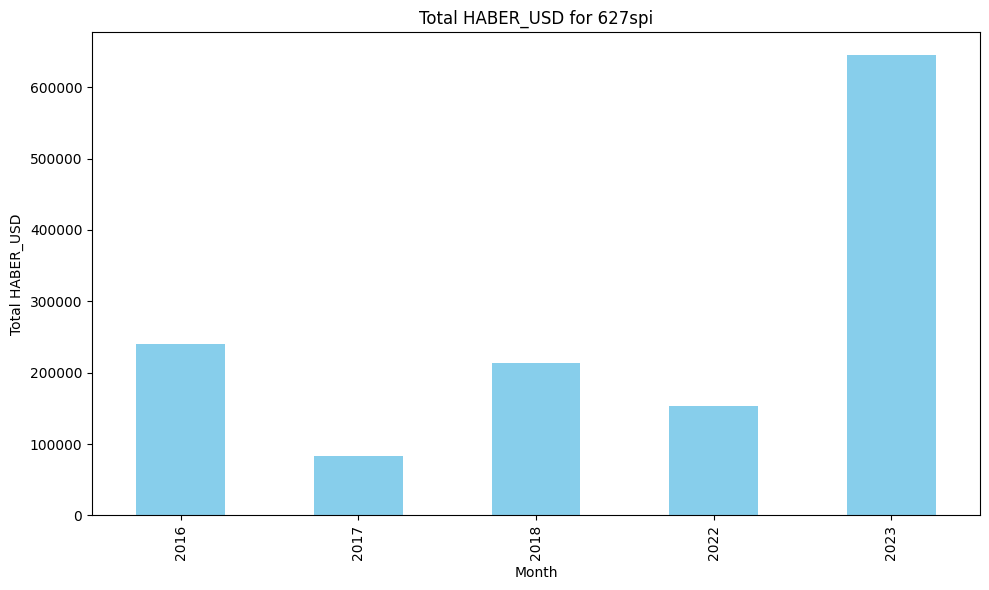

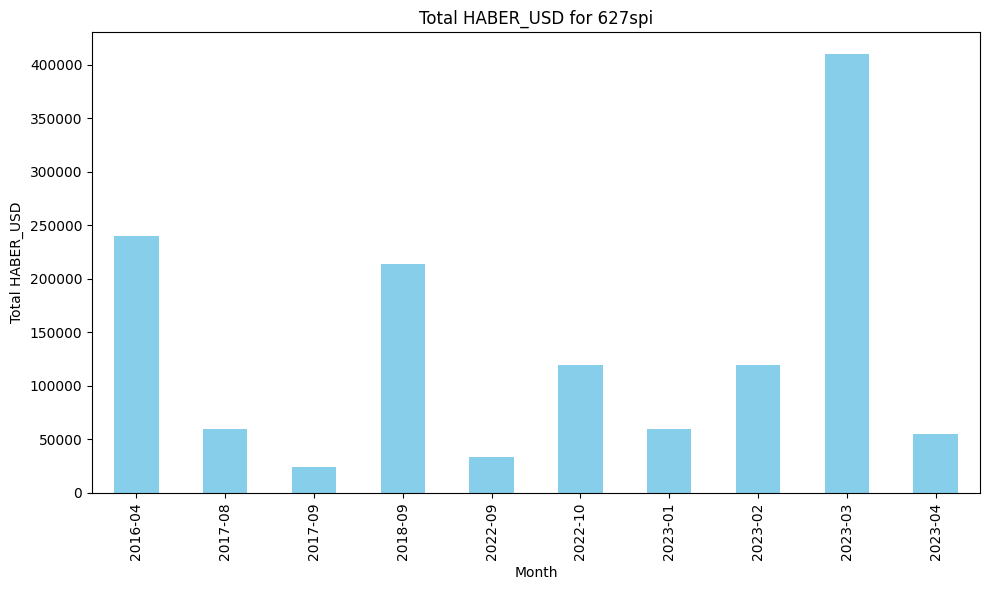

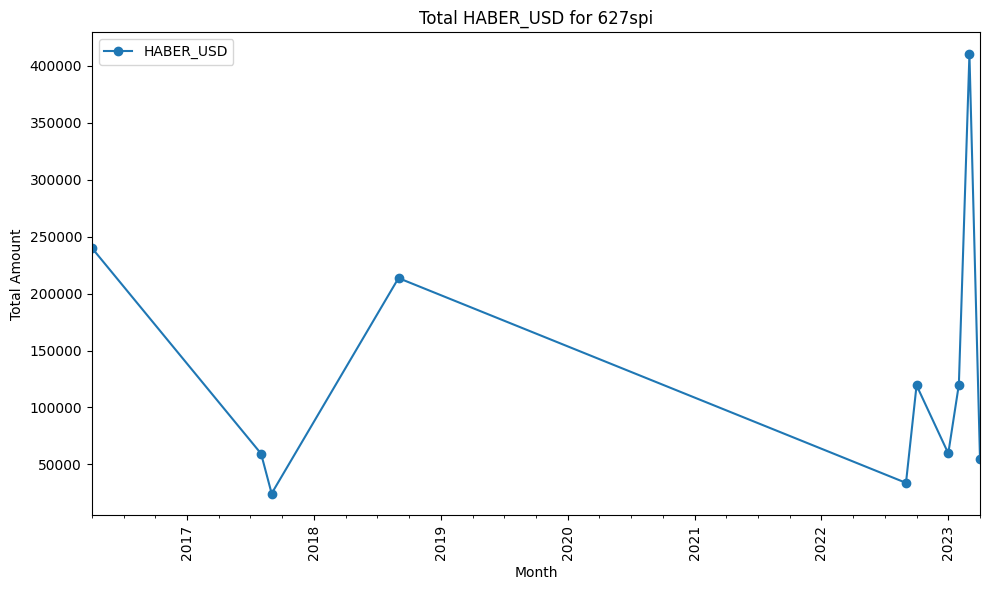

La compra media en el proveedor 627spi en 2016 fue de 120007.72 USD, y la mediana fue de 120007.72 USD.El total de compras fue de 240015.43 USD y la cantidad de operaciones fue de 2.0.
La compra media en el proveedor 627spi en 2017 fue de 20986.67 USD, y la mediana fue de 20273.18 USD.El total de compras fue de 83946.67 USD y la cantidad de operaciones fue de 4.0.
La compra media en el proveedor 627spi en 2018 fue de 106781.46 USD, y la mediana fue de 106781.46 USD.El total de compras fue de 213562.92 USD y la cantidad de operaciones fue de 2.0.
La compra media en el proveedor 627spi en 2022 fue de 51087.26 USD, y la mediana fue de 59442.72 USD.El total de compras fue de 153261.78 USD y la cantidad de operaciones fue de 3.0.
La compra media en el proveedor 627spi en 2023 fue de 161146.85 USD, y la mediana fue de 89845.36 USD.El total de compras fue de 644587.38 USD y la cantidad de operaciones fue de 4.0.


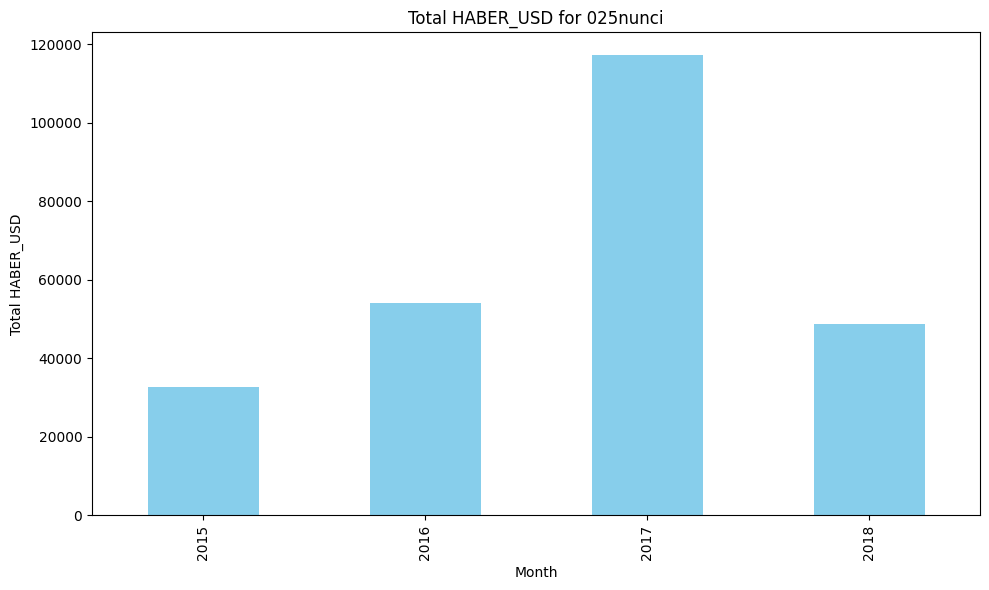

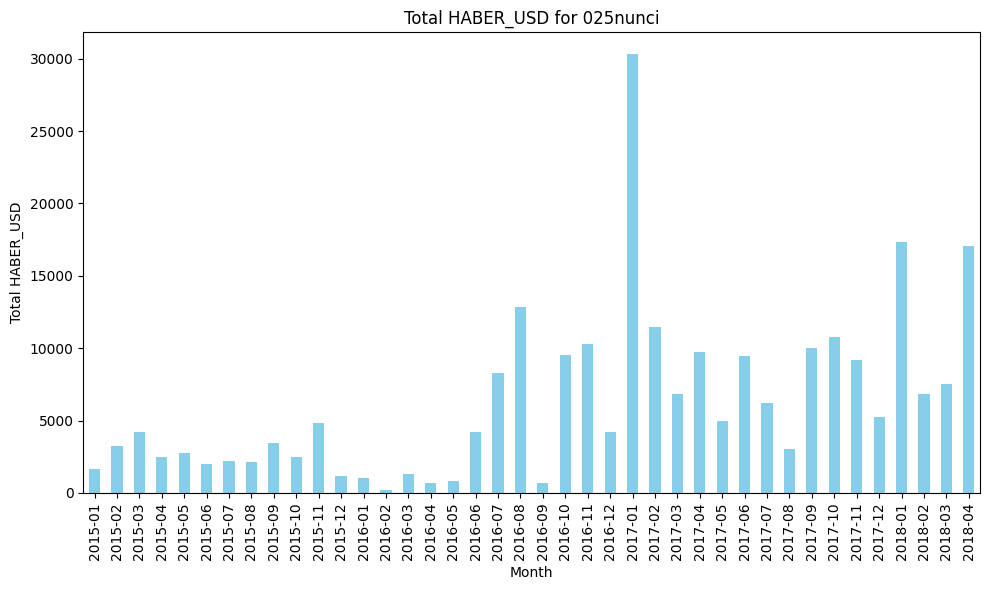

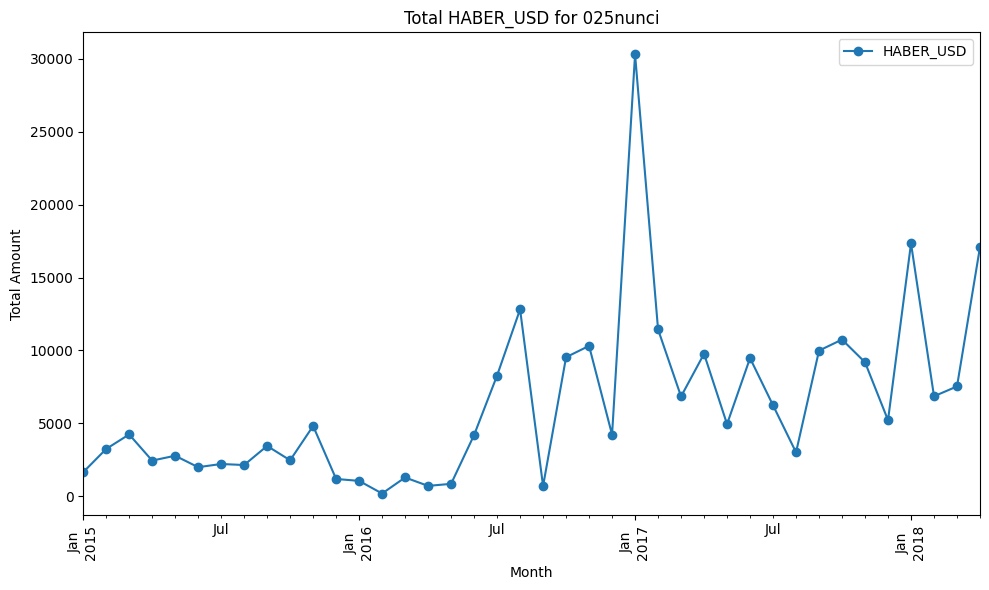

La compra media en el proveedor 025nunci en 2015 fue de 283.59 USD, y la mediana fue de 131.31 USD.El total de compras fue de 32612.71 USD y la cantidad de operaciones fue de 115.0.
La compra media en el proveedor 025nunci en 2016 fue de 404.08 USD, y la mediana fue de 110.65 USD.El total de compras fue de 54147.26 USD y la cantidad de operaciones fue de 134.0.
La compra media en el proveedor 025nunci en 2017 fue de 808.03 USD, y la mediana fue de 311.13 USD.El total de compras fue de 117164.53 USD y la cantidad de operaciones fue de 145.0.
La compra media en el proveedor 025nunci en 2018 fue de 856.44 USD, y la mediana fue de 297.26 USD.El total de compras fue de 48816.95 USD y la cantidad de operaciones fue de 57.0.


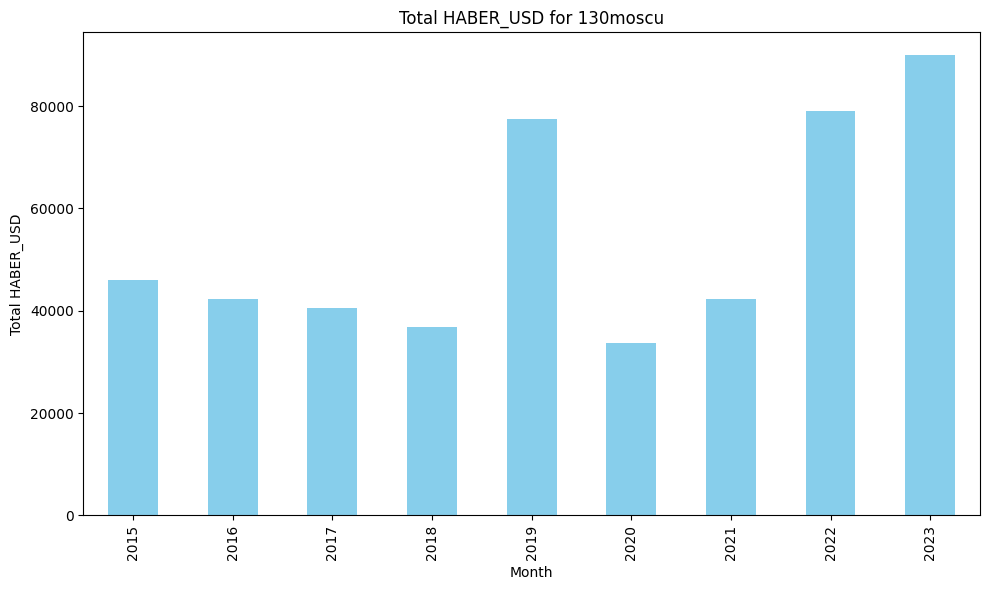

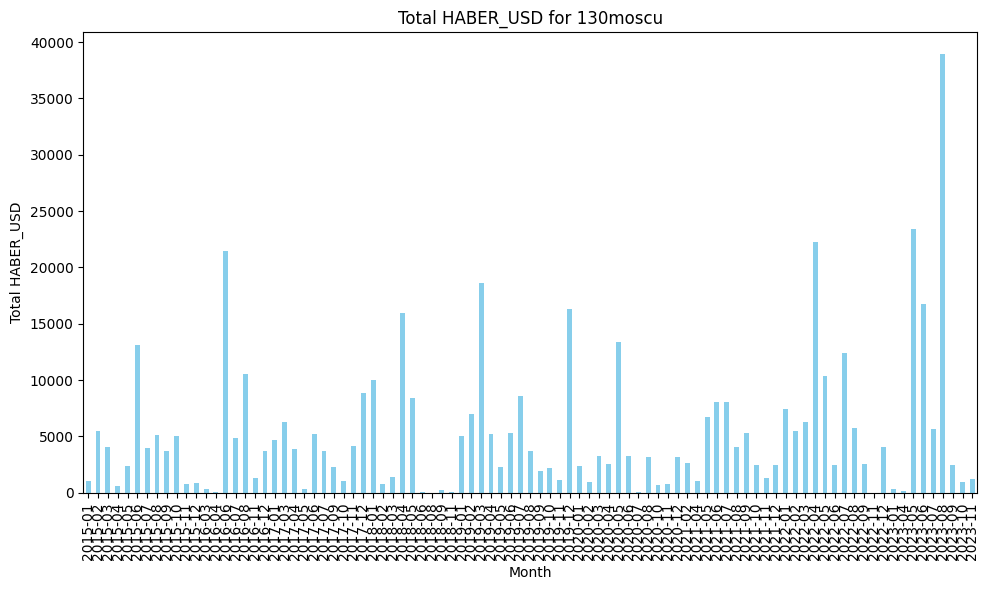

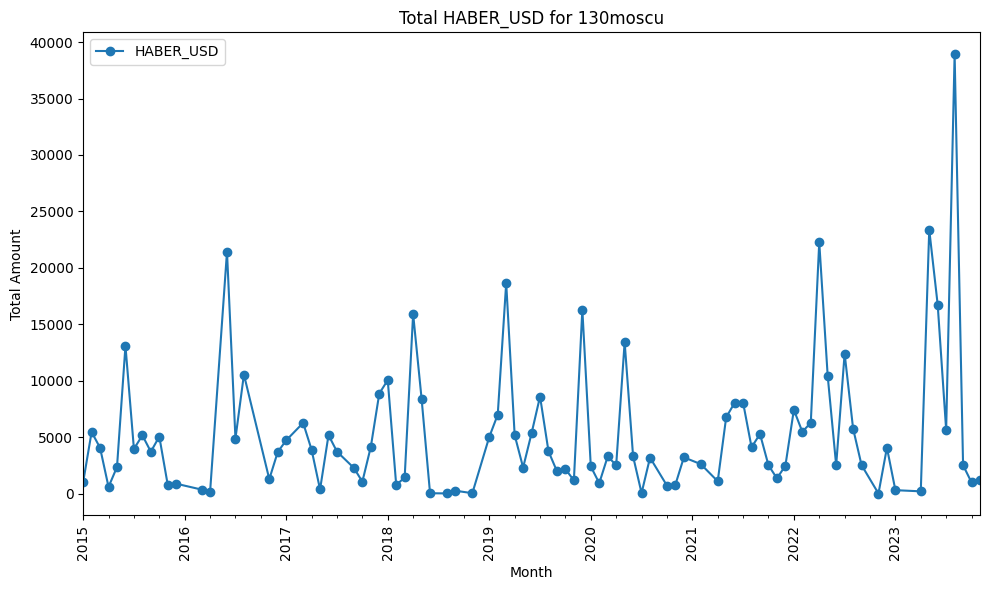

La compra media en el proveedor 130moscu en 2015 fue de 886.20 USD, y la mediana fue de 349.40 USD.El total de compras fue de 46082.32 USD y la cantidad de operaciones fue de 52.0.
La compra media en el proveedor 130moscu en 2016 fue de 983.47 USD, y la mediana fue de 517.52 USD.El total de compras fue de 42289.02 USD y la cantidad de operaciones fue de 43.0.
La compra media en el proveedor 130moscu en 2017 fue de 1686.01 USD, y la mediana fue de 960.34 USD.El total de compras fue de 40464.15 USD y la cantidad de operaciones fue de 24.0.
La compra media en el proveedor 130moscu en 2018 fue de 1118.34 USD, y la mediana fue de 612.85 USD.El total de compras fue de 36905.31 USD y la cantidad de operaciones fue de 33.0.
La compra media en el proveedor 130moscu en 2019 fue de 900.91 USD, y la mediana fue de 423.08 USD.El total de compras fue de 77478.26 USD y la cantidad de operaciones fue de 86.0.
La compra media en el proveedor 130moscu en 2020 fue de 675.92 USD, y la mediana fue de 413.6

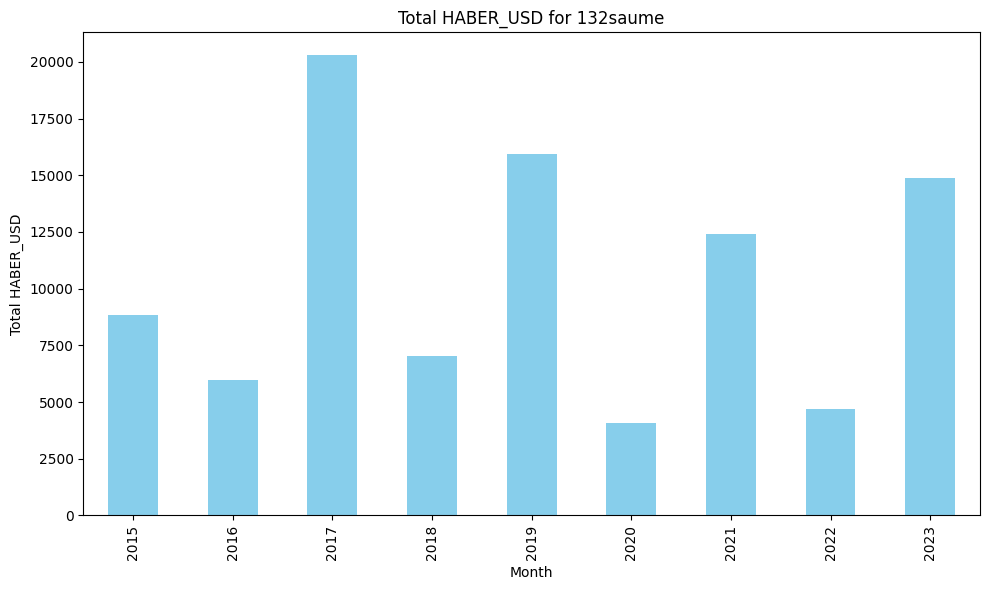

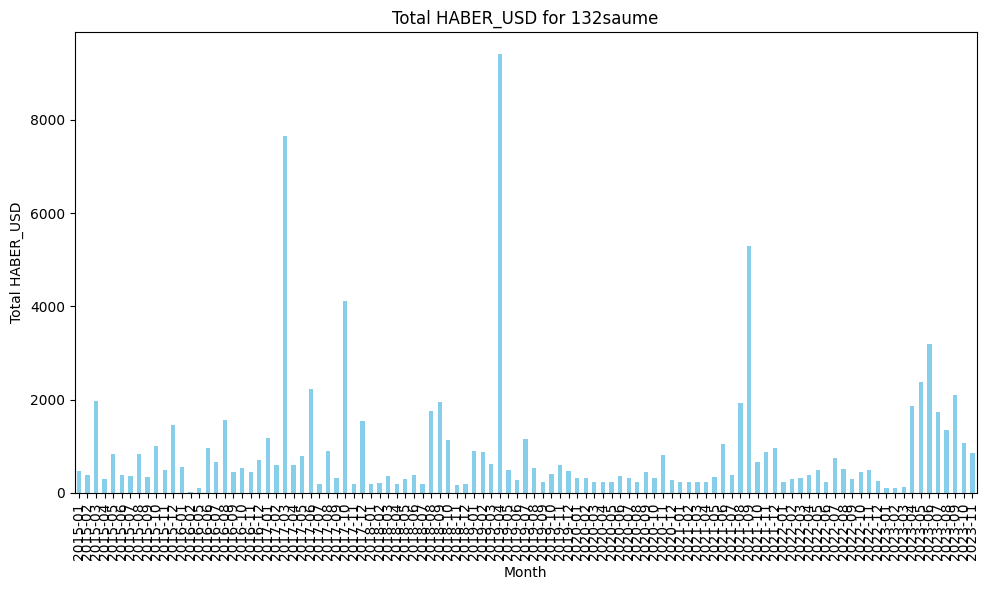

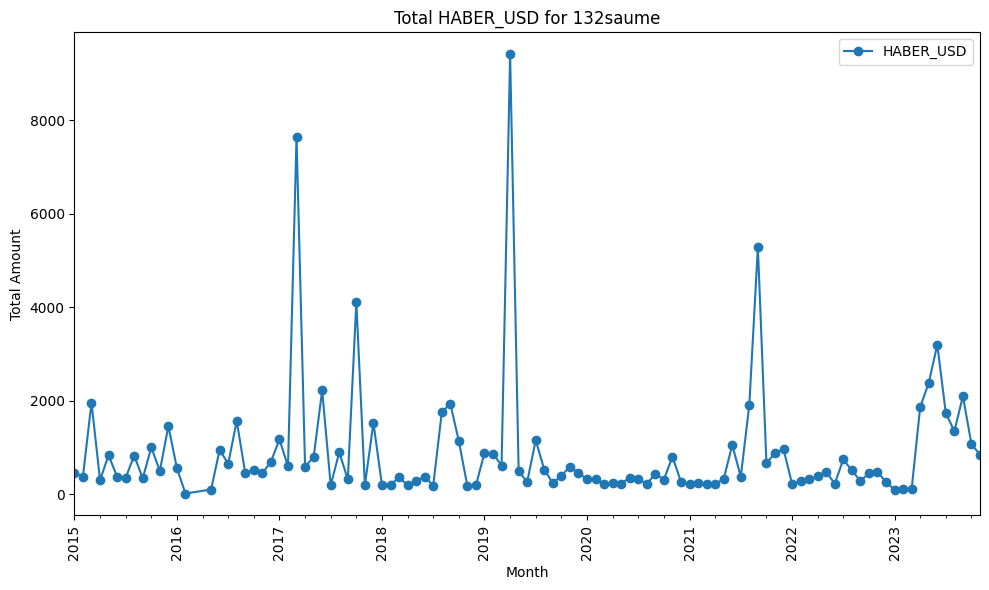

La compra media en el proveedor 132saume en 2015 fue de 157.60 USD, y la mediana fue de 94.48 USD.El total de compras fue de 8825.77 USD y la cantidad de operaciones fue de 56.0.
La compra media en el proveedor 132saume en 2016 fue de 139.37 USD, y la mediana fue de 117.32 USD.El total de compras fue de 5992.79 USD y la cantidad de operaciones fue de 43.0.
La compra media en el proveedor 132saume en 2017 fue de 209.12 USD, y la mediana fue de 69.90 USD.El total de compras fue de 20284.74 USD y la cantidad de operaciones fue de 97.0.
La compra media en el proveedor 132saume en 2018 fue de 242.02 USD, y la mediana fue de 178.38 USD.El total de compras fue de 7018.61 USD y la cantidad de operaciones fue de 29.0.
La compra media en el proveedor 132saume en 2019 fue de 279.47 USD, y la mediana fue de 103.63 USD.El total de compras fue de 15930.04 USD y la cantidad de operaciones fue de 57.0.
La compra media en el proveedor 132saume en 2020 fue de 131.66 USD, y la mediana fue de 100.00 USD.E

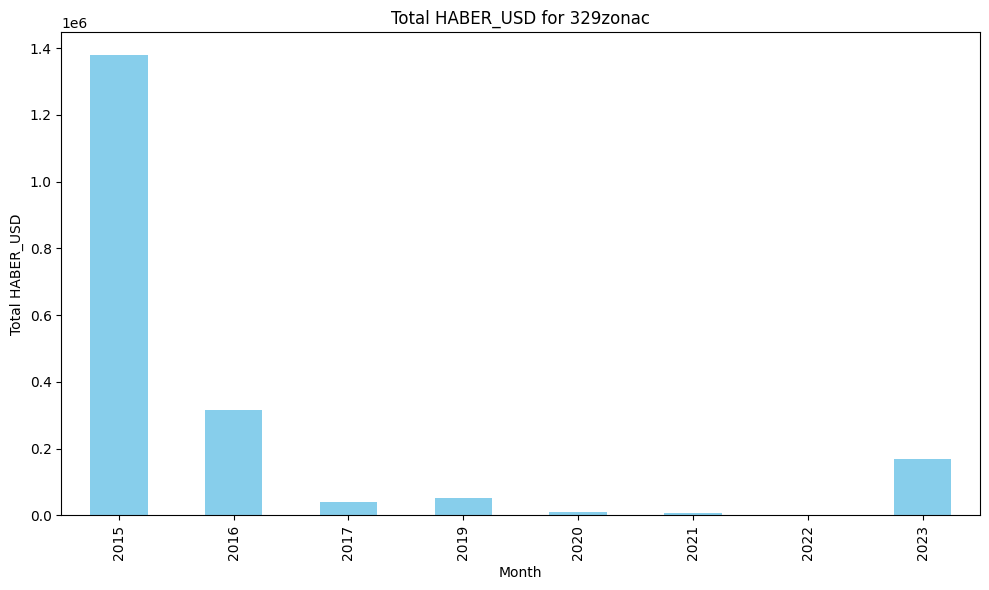

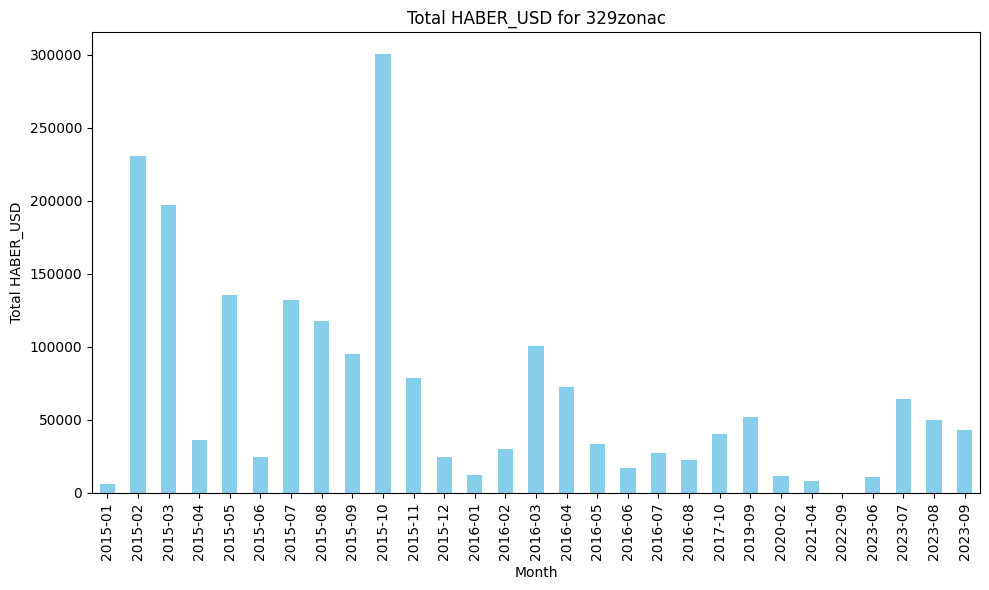

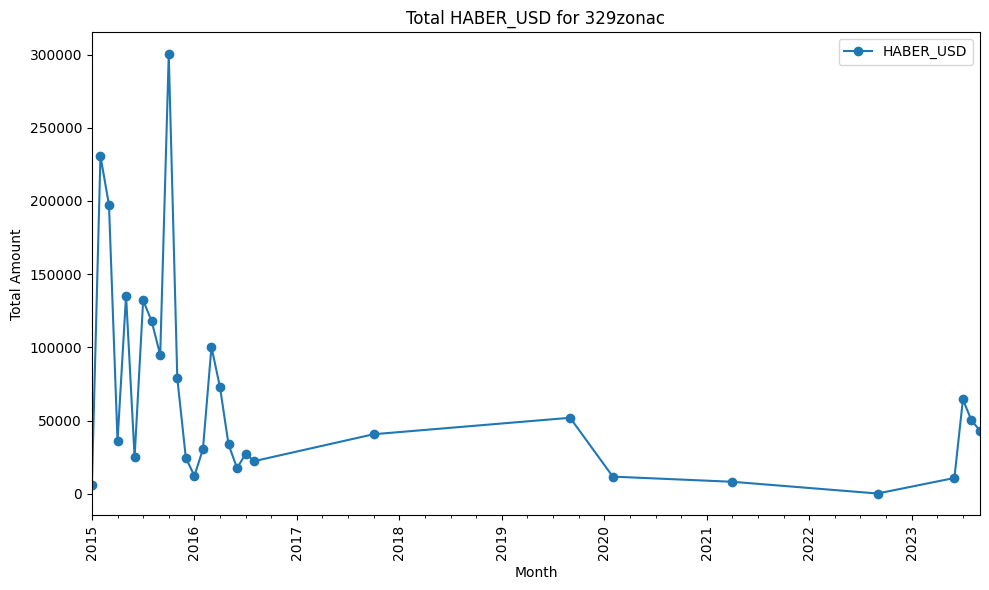

La compra media en el proveedor 329zonac en 2015 fue de 32818.00 USD, y la mediana fue de 32183.35 USD.El total de compras fue de 1378356.04 USD y la cantidad de operaciones fue de 42.0.
La compra media en el proveedor 329zonac en 2016 fue de 10536.42 USD, y la mediana fue de 7966.13 USD.El total de compras fue de 316092.72 USD y la cantidad de operaciones fue de 30.0.
La compra media en el proveedor 329zonac en 2017 fue de 13545.09 USD, y la mediana fue de 12396.65 USD.El total de compras fue de 40635.27 USD y la cantidad de operaciones fue de 3.0.
La compra media en el proveedor 329zonac en 2019 fue de 17290.97 USD, y la mediana fue de 16094.12 USD.El total de compras fue de 51872.92 USD y la cantidad de operaciones fue de 3.0.
La compra media en el proveedor 329zonac en 2020 fue de 5833.81 USD, y la mediana fue de 5833.81 USD.El total de compras fue de 11667.63 USD y la cantidad de operaciones fue de 2.0.
La compra media en el proveedor 329zonac en 2021 fue de 8142.49 USD, y la medi

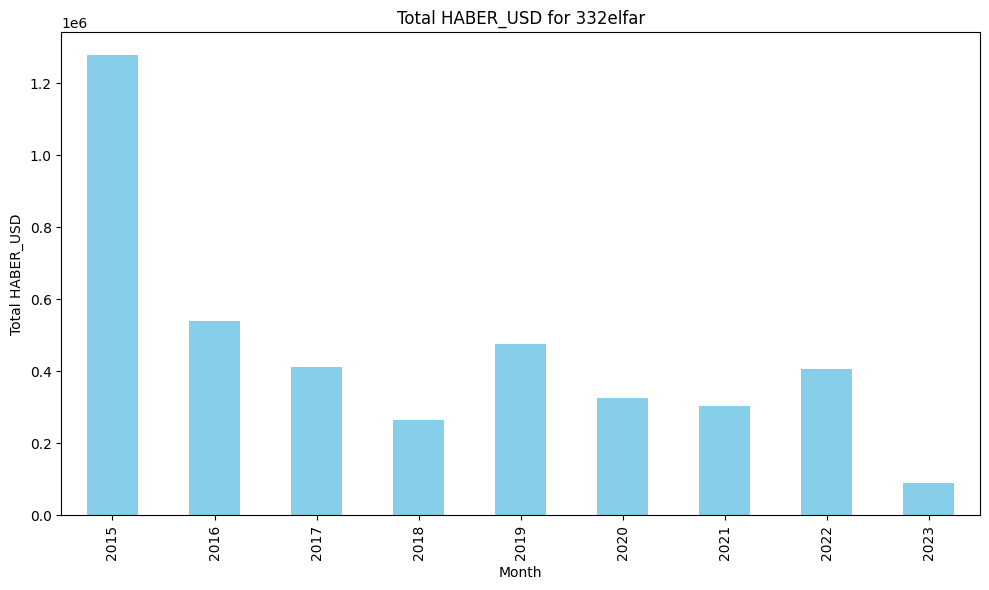

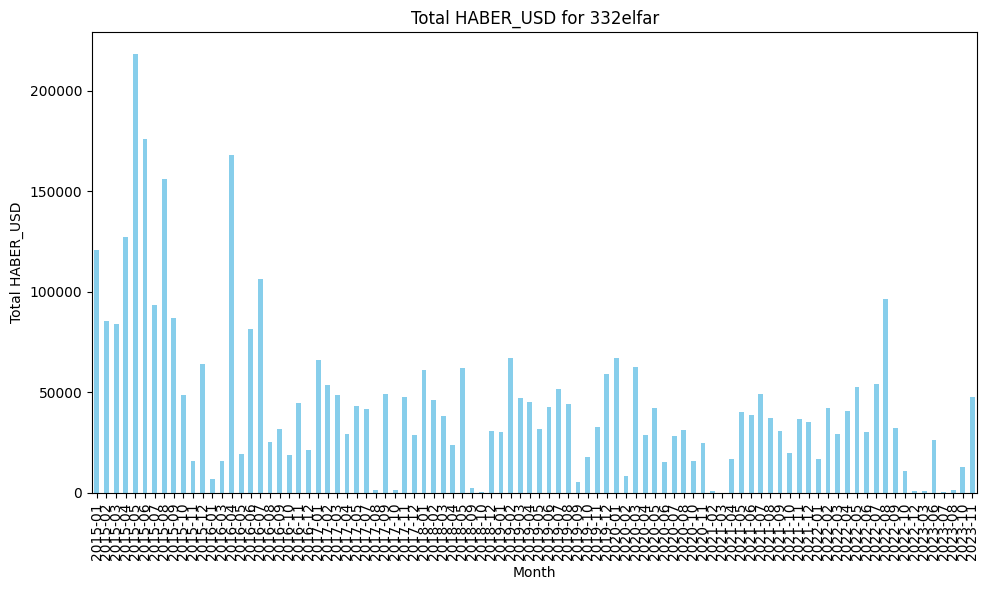

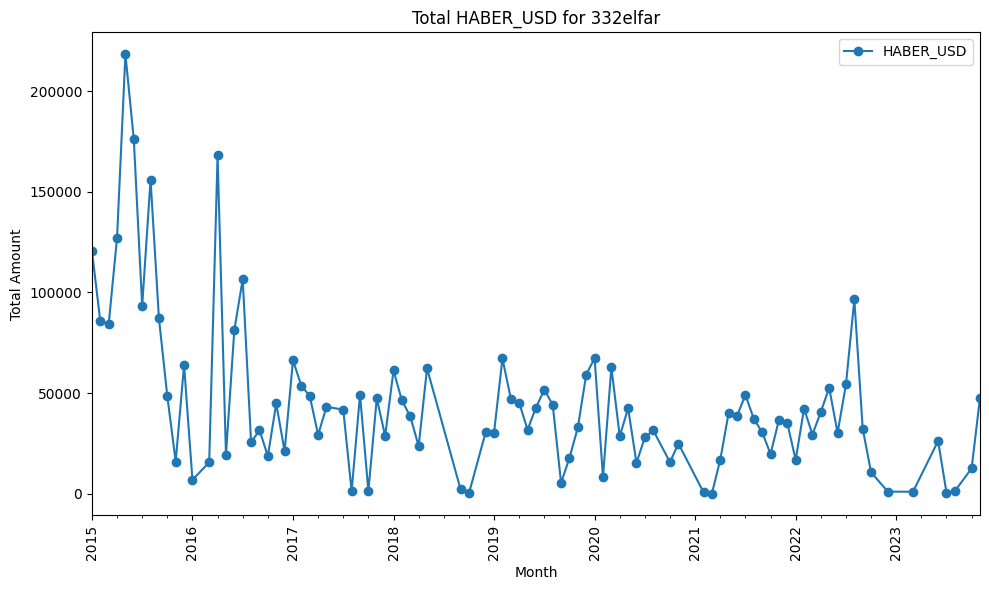

La compra media en el proveedor 332elfar en 2015 fue de 24091.23 USD, y la mediana fue de 18095.33 USD.El total de compras fue de 1276834.98 USD y la cantidad de operaciones fue de 53.0.
La compra media en el proveedor 332elfar en 2016 fue de 11482.16 USD, y la mediana fue de 3521.13 USD.El total de compras fue de 539661.54 USD y la cantidad de operaciones fue de 47.0.
La compra media en el proveedor 332elfar en 2017 fue de 12833.37 USD, y la mediana fue de 10932.03 USD.El total de compras fue de 410667.90 USD y la cantidad de operaciones fue de 32.0.
La compra media en el proveedor 332elfar en 2018 fue de 13248.98 USD, y la mediana fue de 12198.94 USD.El total de compras fue de 264979.66 USD y la cantidad de operaciones fue de 20.0.
La compra media en el proveedor 332elfar en 2019 fue de 14421.59 USD, y la mediana fue de 16800.18 USD.El total de compras fue de 475912.62 USD y la cantidad de operaciones fue de 33.0.
La compra media en el proveedor 332elfar en 2020 fue de 12039.37 USD, 

In [28]:
# Bloque de Implementación

# Iterate through each file in the folder
for file_name in files:
    if file_name.endswith('.xls') or file_name.endswith('.xlsx'):  # Process only Excel files
        file_path = os.path.join(folder_path, file_name)

        # Import file as DataFrame
        working_df = import_excel_file_as_pd_df(file_path)

        # Executing functions
        merged_df_by_function = merge_tdc_proov(working_df, usd_to_ars_df)
        working_df_usd = calculate_haber_usd(merged_df_by_function)
        monthly_sum_haber_usd = calculate_monthly_sum_two_steps(working_df_usd, 'HABER_USD', 'M')
        monthly_sum_haber = calculate_monthly_sum_two_steps(working_df_usd, 'HABER_USD', 'M')
        yearly_sum_haber_usd=calculate_monthly_sum_two_steps(working_df_usd, 'HABER_USD', 'Y')

        # Plotting
        plot_monthly_sum_with_filename(yearly_sum_haber_usd, 'HABER_USD', file_path,'bar')
        plot_monthly_sum_with_filename(monthly_sum_haber_usd, 'HABER_USD',file_path, 'bar')
        plot_monthly_sum_with_filename(monthly_sum_haber_usd, 'HABER_USD', file_path,'line')

        # Metrics
        report_metrics(merged_df_by_function)


print(result_df)


C:\Users\juanm\OneDrive\Documents\CODER DATA ANALYTICS\GitHub\Prueba_Nacho\files\proovs_xlsx\112garri.xlsx period
2015     9804.104666
2016     4557.047177
2017     6802.646186
2018    43589.535526
2019     8046.287004
2020     8893.316176
2021     7295.131117
2022    27805.132566
2023    15074.716397
Freq: A-DEC, Name: HABER_USD, dtype: float64
<class 'pandas.core.series.Series'>
C:\Users\juanm\OneDrive\Documents\CODER DATA ANALYTICS\GitHub\Prueba_Nacho\files\proovs_xlsx\048korzi.xlsx period
2015    9380.488411
2018    6579.237413
2022    5604.720000
Freq: A-DEC, Name: HABER_USD, dtype: float64
<class 'pandas.core.series.Series'>
C:\Users\juanm\OneDrive\Documents\CODER DATA ANALYTICS\GitHub\Prueba_Nacho\files\proovs_xlsx\500domin.xlsx period
2015     1438.831455
2016     3234.892492
2017     4979.935424
2018     6581.584950
2019     2020.573290
2020    36382.830199
2021     5166.387980
2022     9451.942952
2023    12109.144470
Freq: A-DEC, Name: HABER_USD, dtype: float64
<class 'panda

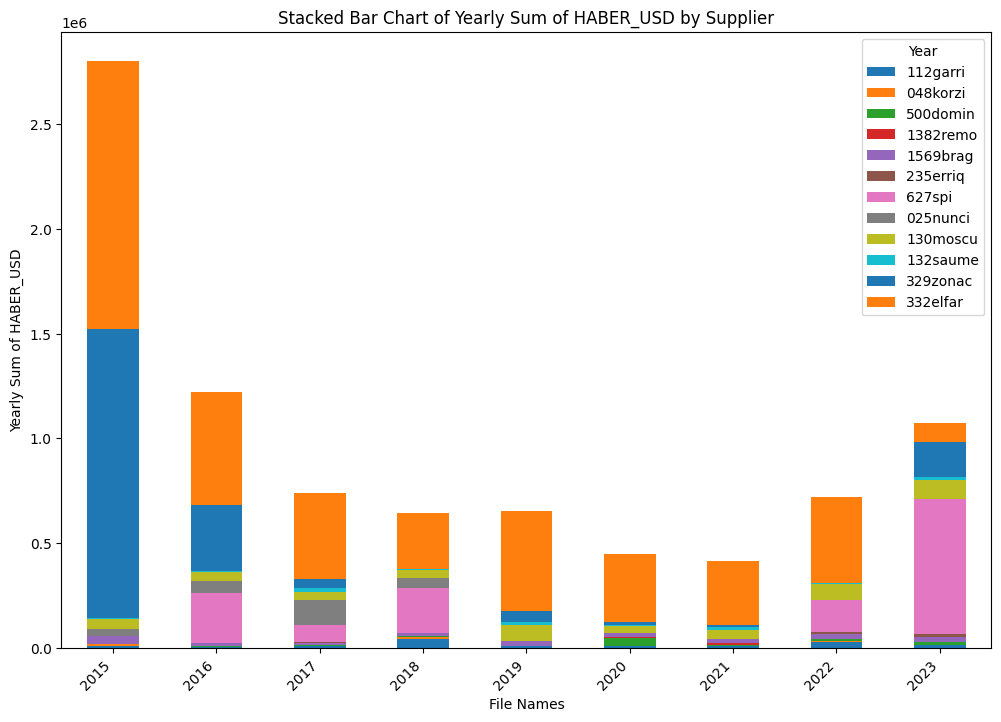

In [29]:
# In this Block I will analize the importance of each supplier every year
# Initialize an empty dictionary to store results
results_dict = {}
# Iterate through each file in the folder
for file_name in files:
    if file_name.endswith('.xls') or file_name.endswith('.xlsx'):  # Process only Excel files
        file_path = os.path.join(folder_path, file_name)
        file_name = get_file_name(file_path)

        # Import file as DataFrame
        working_df = import_excel_file_as_pd_df(file_path)

        # Executing functions
        merged_df_by_function = merge_tdc_proov(working_df, usd_to_ars_df)
        working_df_usd = calculate_haber_usd(merged_df_by_function)
        yearly_sum_haber_usd=calculate_monthly_sum_two_steps(working_df_usd, 'HABER_USD', 'Y')

        # Store the result in the dictionary
        results_dict[file_name] = yearly_sum_haber_usd

        print(file_path, yearly_sum_haber_usd)
        print(type(yearly_sum_haber_usd))

result_df = pd.DataFrame(results_dict)

print(result_df)


# Plot the stacked bar chart
ax = result_df.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_ylabel('Yearly Sum of HABER_USD')
ax.set_xlabel('File Names')
ax.set_title('Stacked Bar Chart of Yearly Sum of HABER_USD by Supplier')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Year')

plt.show()